# Pipeline de Dados do Telegram 
### Autor: [Fernando Oliveira da Silva Gomes](https://www.linkedin.com/in/fosg)

---

---

## 1. Configurando o *bot*.

Criei um *bot* no Telegram e o chamei de "Pesquisa Financeira Bot" (username: @m43_fernando_bot). Como o nome já sugere, o objetivo aqui é fazer uma pesquisa a respeito da situação financeira (sem entrar em detalhes sensíveis) dos usuários. As informações coletadas pelo bot são:

 - sexo;
 - idade;
 - usa banco digital como principal conta bancária;
 - possui investimentos em renda fixa ou variável.

Além disso é necessário configurar uma resposta para comandos inválidos e um agradecimento para quem concluir o questionário. Entretando, a maior parte dessas configurações não é feita no próprio Telegram, e sim programadas em código.

### 1.1 Amazon Web Services (AWS)

Utilizei os serviços de programação em núvem da Amazon para lidar com as mensagens. Primeiramente é necessário vincular o *bot* à AWS, e isso é feito através do serviço API Gateway, informando o API Token do do *bot*. 

Após o Gateway receber os dados da API do Telegram, ele precisa enviar para o serviço responsável pelo processamento. Para grandes volumes de dados AWS EC2 é a opção mais interessante, mas é mais custosa. Para esse projeto, que precisa processar dados esporadicamente, o serviço AWS Lambda é suficiente e praticamente sem custo.

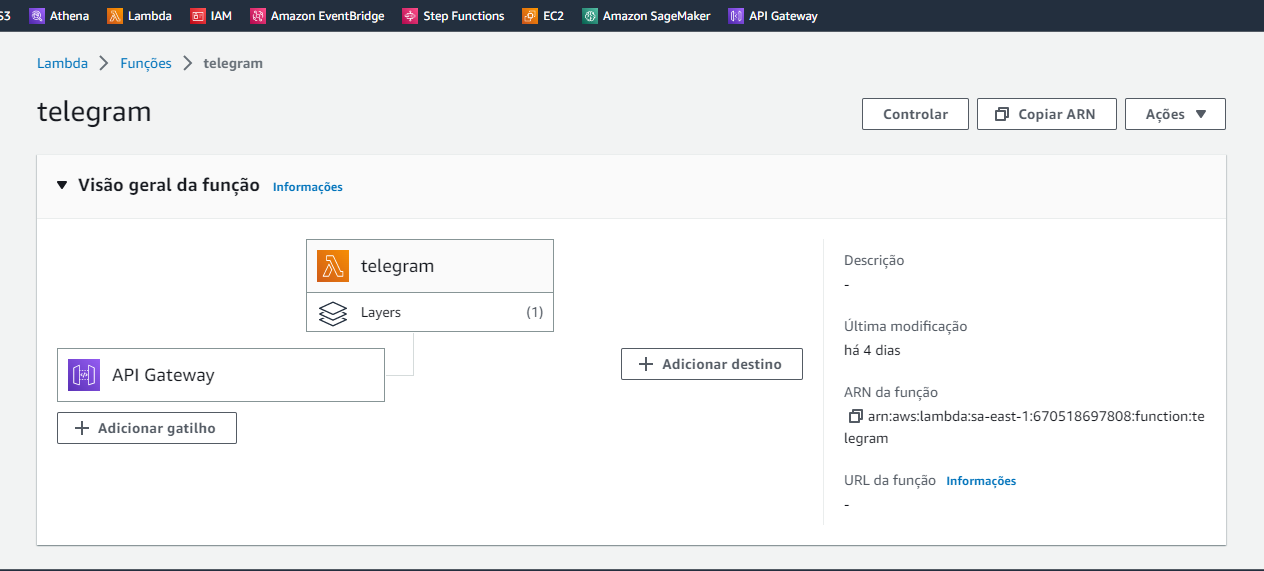

Dentro do serviço Lambda, criei uma função (linguagem python - 3.8) chamada Telegram. É necessário conceder a permissão "*AWSLambdaEdgeExecutionRole*" e também a permissão para escrever arquivos no S3. 

Configurei variáveis de ambiente para o token do *bot* e para o *bucket* do S3 para onde as mensagens são enviadas após o processamento.

Por segurança, decidi aumentar o *timeout* da função para 10 segundos - por padrão a função roda por 3 segundos e, se o processo não for concluído nesse tempo,a execução é interrompida. 

Por fim, é necessário também configurar uma camada (layer), pois o código precisa de bibliotecas que não estão instaladas nos servidores da AWS. Crie no seu computador uma pasta chamada python e instale nessa pasta a biblioteca que lida com API do telegram (eu usei a **telebot**). Comprima a pasta como .zip e faça o upload para a camada da função Lambda. 

Dessa forma não haverá problema para importar essas bibliotecas no código python.

### 1.2 Programando o *bot*

Lidar com as mensagens não é trivial, principalmente programar uma resposta com a pergunta subsequente. Isso acontece porque a função Lambda lida com uma mensagem de cada vez. Esse problema pode ser resolvido de várias formas.

Optei por utilizar botões, por considera-los mais fáceis de processar e por diminuir o trabalho dos voluntários que responderão as perguntas. Também optei por enviar uma pergunta de cada vez, para não gerar confusão.

Para salvar as respostas, utilizei a propriedade "*callback_data*" dos botões, salvando em cada botão as respostas anteriores de uma forma invisível para o usuário. Basicamente usando os servidores do telegram, e não a AWS, para salvar essa informação durante o processo. Não sei se é forma mais otimizada de resolver esse problema, mas funciona adequadamente nesse projeto.

No código abaixo estão definidas três funções:

 - **start()** que recebe o id de uma conversa com um usuário que acionou o comando /start e retorna pra ele a primeira pergunta;
 - **handle_callbak_query()** que lida com o acionamento de um botão, recebendo a informação sobre o botão acionado, salvando a resposta e enviando a pergunta seguinte;
 - **lambda_handler()** que lida com todas as mensagens, aciona as outras funções quando necessário, responde comandos inválidos, agradece ao final da pesquisa e envia os dados da conversa para o S3 



In [ ]:
import os
import json
import logging

from datetime import datetime, timezone, timedelta

import boto3
import telebot
from telebot.types import InlineKeyboardMarkup
from telebot.types import InlineKeyboardButton

BUCKET = os.environ['AWS_S3_BUCKET']
TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])
BOT_TOKEN = os.environ['BOT_TOKEN']

bot = telebot.TeleBot(BOT_TOKEN)


def start(chat_id):
    #send question 1
  markup = InlineKeyboardMarkup() 
  bt1 = InlineKeyboardButton('Sim', callback_data = "1S")
  bt2 = InlineKeyboardButton('Não', callback_data = "1N")
  markup.add(bt1, bt2)
  bot.send_message(chat_id,"Olá. Sua principal conta bancária é digital, como uma conta do Nubank?",
                   reply_markup = markup)
  


def handle_callback_query(callback, answers):
  chat_id = callback["message"]["chat"]["id"]
  markup = InlineKeyboardMarkup()
    
  #Buttons for question 2

  bt3 = InlineKeyboardButton('Não/outros', callback_data = answers + "2o")
  bt4 = InlineKeyboardButton('Renda fixa', callback_data = answers + "2f")
  bt5 = InlineKeyboardButton('Renda variável', callback_data = answers + "2v")
  
 #Buttons for question 3

  bt6 = InlineKeyboardButton('Masculino', callback_data = answers + "3m")
  bt7 = InlineKeyboardButton('Feminino', callback_data = answers + "3f")
  
  #Buttons for question 4

  bt18 = InlineKeyboardButton('Até 18', callback_data = answers + "18")
  bt25 = InlineKeyboardButton('19-25', callback_data = answers + "25")
  bt30 = InlineKeyboardButton('26-30', callback_data = answers + "30")
  bt40 = InlineKeyboardButton('31-40', callback_data = answers + "40")
  bt50 = InlineKeyboardButton('41-50', callback_data = answers + "50")
  bt51 = InlineKeyboardButton('mais de 50', callback_data = answers + "51")
  
  if  len(answers) == 2: #one question answered
    markup.add(bt3, bt4, bt5)
    bot.send_message(chat_id,'Você atualmente investe em renda fixa ou renda variável?',reply_markup = markup)
  elif len(answers) == 4: #two questions answered
    markup.add(bt6, bt7)
    bot.send_message(chat_id,'Qual é o seu gênero?',reply_markup = markup)
  elif len(answers) == 6:#three questions answered
    markup.add(bt18, bt25, bt30, bt40, bt50, bt51)
    bot.send_message(chat_id,'Qual é a sua faixa etária?',reply_markup = markup)
    
    
    
def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway e a escreve, 
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'
  client = boto3.client('s3')

  # código principal

  try:
    body = event["body"]
    update = json.loads(body)
    answers = ''
    
    if "message" in update:
      message_part = update["message"]
      text = message_part["text"]
      chat_id = message_part["chat"]["id"]
      
      if "entities" in message_part:
        ent_type = message_part["entities"][0]["type"]
        if "/start" in text:
          start(chat_id)
        else:
          bot.send_message(chat_id, "Desculpe, não reconheço esse comando")
      else:
        bot.send_message(chat_id, "Desculpe, não reconheço esse comando")
     
    elif "callback_query" in update:
      callback = update["callback_query"]
      answers = callback["data"]
      chat_id = callback["message"]["chat"]["id"]
      
      if len(answers) > 6:
        
        update["answers"] = answers
        
        bot.send_message(chat_id, "Muito obrigado por participar. Tenha um bom dia!")
        with open(f'/tmp/{filename}', mode='w', encoding='utf8') as fp:
          json.dump(update, fp)
       
        client.upload_file(f"/tmp/{filename}", BUCKET, f'telegram/context_date={date}/{filename}')
      
      handle_callback_query(callback, answers)
      
  except Exception as exc:
    logging.error(msg=exc)
    
    return dict(statusCode="500")
  else:
    return dict(statusCode="200")
  
  


As mensagens processadas são enviadas para um *bucket* da AWS S3, que nomeei de "m44-fernando-raw", armazenadas em pastas que separam as mensagens por dia que foram enviadas.

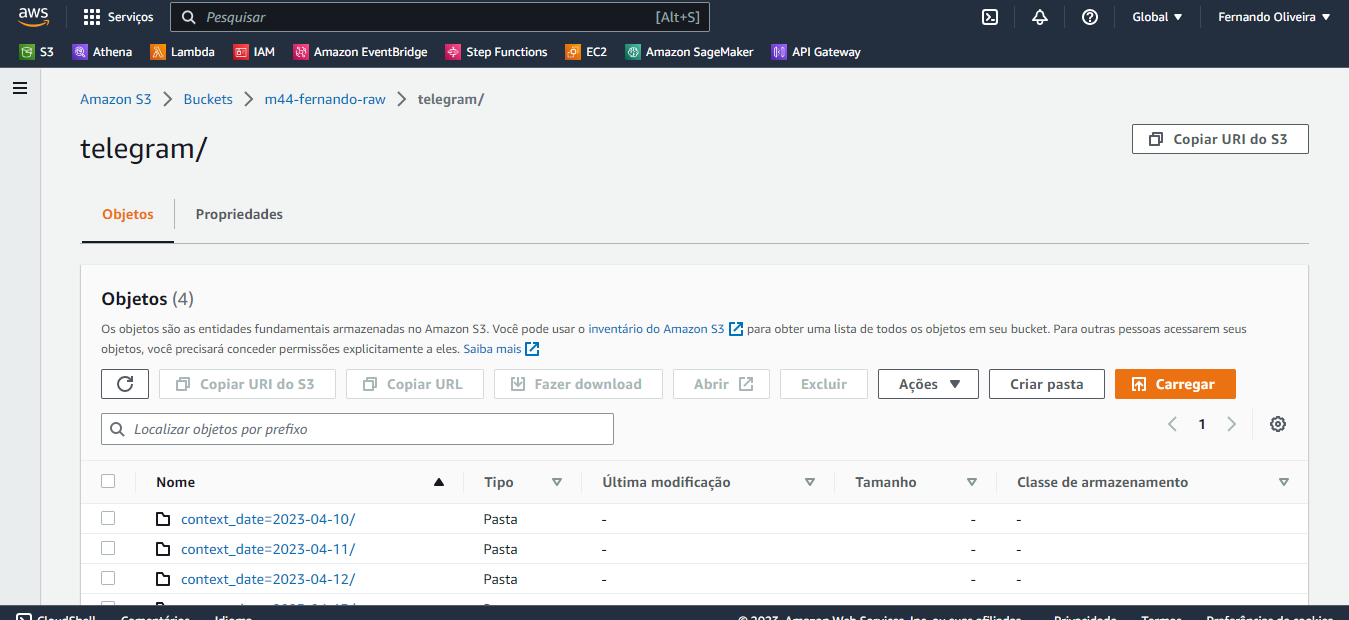

## 2. Enriquecimento dos dados

Concluída a coleta dos dados, a próxima etapa é do enriquecimento dos dados. Essa etapa é importante para permitir uma melhor análise dos dados em etapas posteriores, pois adequa os dados recebidos à estrtura da ferramenta de análise.

Apesar de não ser necessário nesse projeto, utilizei ferramentas de BigData. Essa escolha torna o processo mais complexo mas permite que esse projeto seja aplicado em escopos maiores.

Para esse enriquecimento, utilizei outra função da AWS Lambda, acionada por gatilho da Amazon Event Bridge, que lê os dados no *bucket* com dado bruto processa e os salva em outro *bucket*, nomeado "pesquisa-telegram"

### 2.1 Função Lambda

A configuração da nova função é bastante similar a da primeira, configurando permissões, variáveis de ambiente e camadas. Nas permissões, deve-se concder permissão para ler e escrever arquivos nos *buckets* S3. As variáveis de ambiente aqui são os endereços dos dois *buckets* de onde os dados são retirados e salvos. 

Para a camada, utilizei um arquivo já preparado disponível no github ([link](https://github.com/aws/aws-sdk-pandas/releases/tag/2.16.0)) que fornece as bibliotecas necessárias.

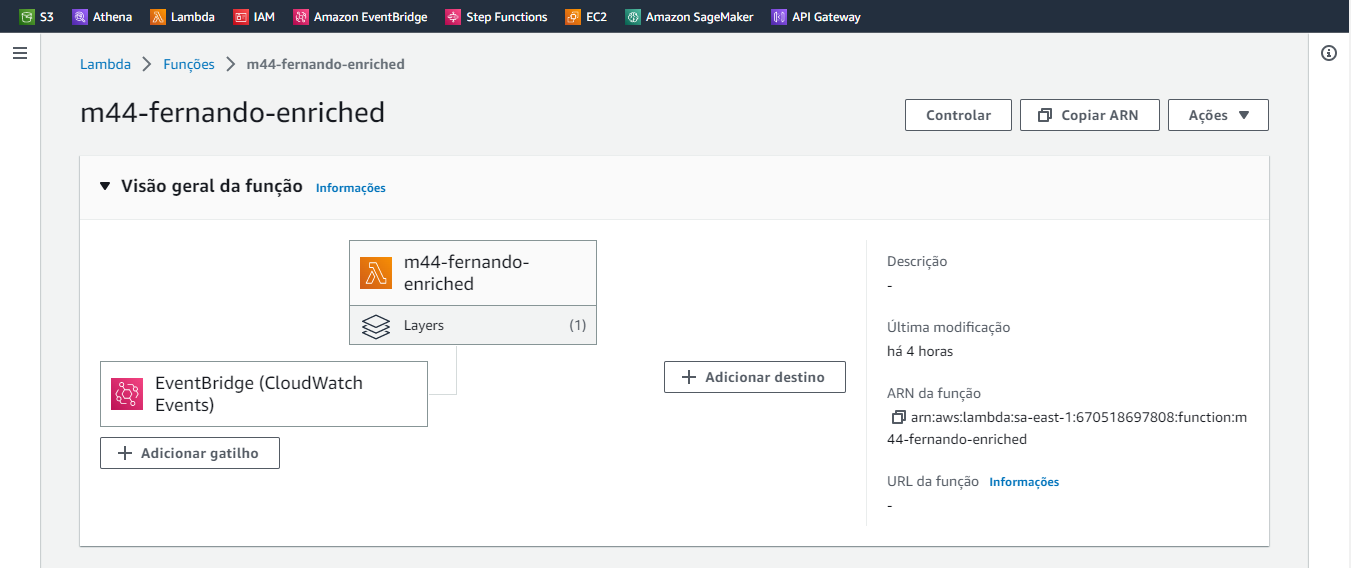

Outra configuração importante é *timeout*, que aqui foi configurado em 5 minutos, uma vez que cada execução interage duas vezes com o S3 e pode lidar com um grande volume de dados ao invés de apenas uma mensagem.

No código abaixo estão definidas duas funções python:
 - **handle_answers()** que recebe a *string* com as respostas do usuário e as converte para o formato compatível com as tabelas do Py Arrow
 - **lambda_handler()** que lê o *bucket* raw, chama a outra função, cria a tabela e a salva os dados no formato .parquet no *bucket* enriched.

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único 
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']
  
  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3') 
  
  try:
       
    date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
    timestamp = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y%m%d%H%M%S%f')
 
    response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

    for content in response['Contents']:

    key = content['Key']
    client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

    with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

      raw = json.load(fp)

      answers = raw["answers"]
      data = raw["callback_query"]["message"]


    parsed_data = dict()
    parsed_data['message_id'] = [data["message_id"]]


    full_parsed_data = handle_answers(answers, parsed_data)

    iter_table = pa.Table.from_pydict(mapping=full_parsed_data)

    if table:

      table = pa.concat_tables([table, iter_table])

    else:

      table = iter_table
      iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")
      
    return True
    
  except Exception as exc:
    logging.error(msg=exc)
    
  return False
      
  ## Data Wrangling
  
def handle_answers(answers: str, parsed_data: dict) -> dict:
  if answers[1] == 'S':
    parsed_data["digital_bank"] = ["yes"]
  else:
    parsed_data["digital_bank"] = ["no"]
  
  if answers[3] == 'o':
    parsed_data["investment"] = ["none/other"]
  elif answers[3] == 'f':
    parsed_data["investment"] = ["fixed"]
  else:
    parsed_data["investment"] = ["stocks"]
    
  if answers[5] == "m":
    parsed_data["sex"] = ["male"]
  else:
    parsed_data["sex"] = ["female"]
    
  if answers[6:] == '18':
    parsed_data["age"] = ["0-18"]
  elif answers[6:] == '25':
    parsed_data["age"] = ["19-25"]
  elif answers[6:] == '30':
    parsed_data["age"] = ["26-30"]
  elif answers[6:] == '40':
    parsed_data["age"] = ["31-40"]
  elif answers[6:] == '50':
    parsed_data["age"] = ["41-50"]
  else:
    parsed_data["age"] = ["51+"]
  
  return parsed_data

A execução dessa função foi configurada na Amazon Event Bridge, sendo realizada todo dia às 01:00 e lendo os arquivos na pasta do dia anterior, dentro do *bucket* raw e salvando no *bucket* enriched, também separando por dia.

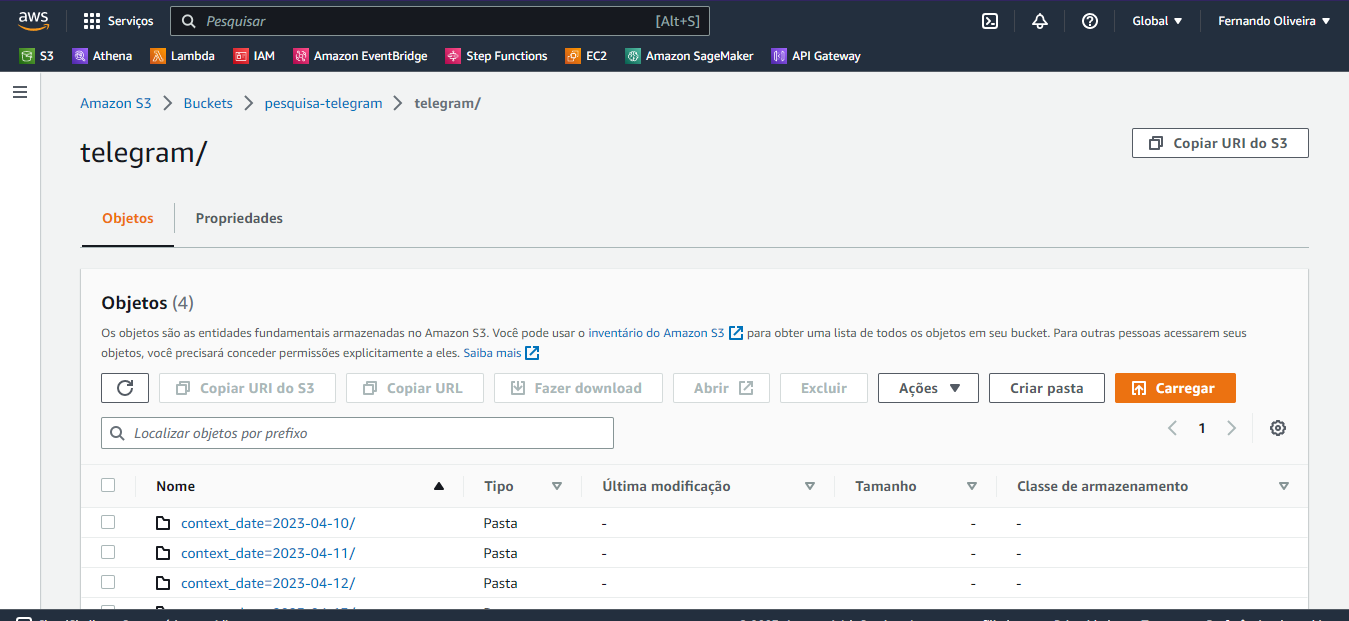

## 3. Análise de Dados

### 3.1 AWS Athena

Com os dados colhidos e devidamente procesados é hora de analisá-los. A amostra aqui é pequena, mas o intuito aqui é apenas exibir o potencial deste pipeline. Primeiramente, criei uma tabela SQL, particionada por dia com o AWS Athena com as colunas:

 - **message_id** contendo o identificador da mensagem do *bot*;
 - **digital_bank** informando se o banco mais usado pelo usuário é digital ou não;
 - **investments** que informa se o usuário investe em renda fixa (fixed), variável (stocks) ou em outra categoria;
 - **sex** que informa o genero do usuário;
 - **age** faixa etária do usuário.
 
Abaixo seguem uma prévia da tabela

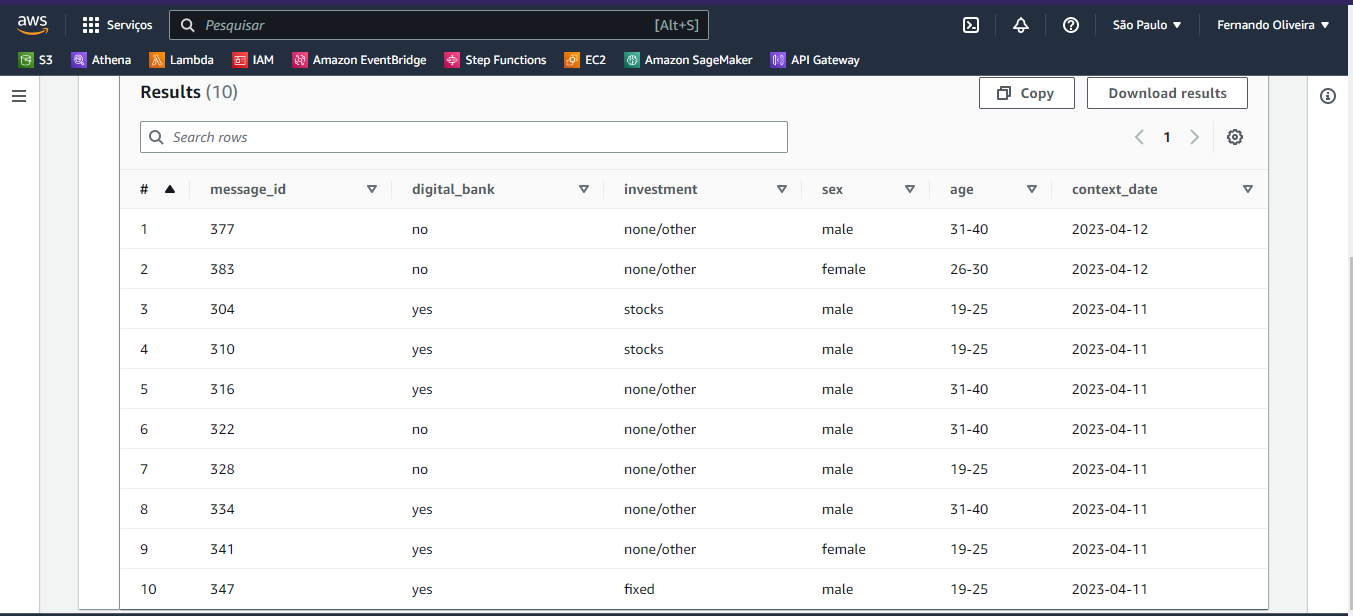

Usando o comando 
```sql 
SELECT COUNT(*), sex FROM "pesquisa" GROUP BY sex 
```
podemos verificar quantos membros de cada gênero existem no dataset 

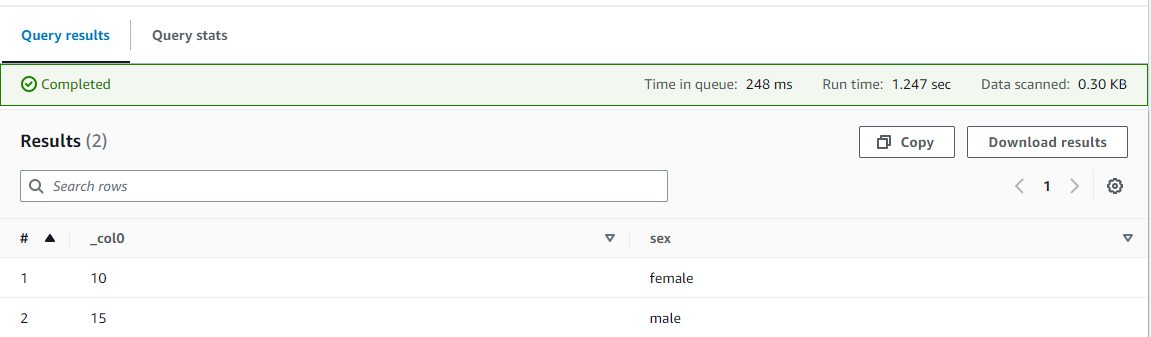

Podemos também verificar como os usuários estão divididosnas faixas etárias
```sql
SELECT COUNT(*) as "Count", age FROM "pesquisa" GROUP BY age
```



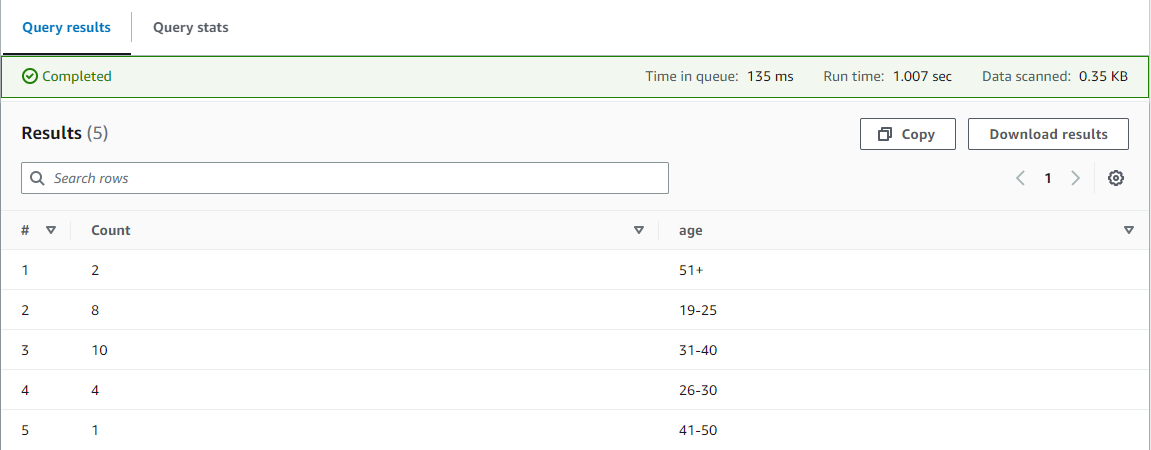

Com o comando 
```sql
SELECT COUNT(*) as "uses digital bank", age FROM "pesquisa" WHERE digital_bank = 'yes' GROUP BY age
```
podemos verificar o número de usuários de contas digitais por faixa etária.

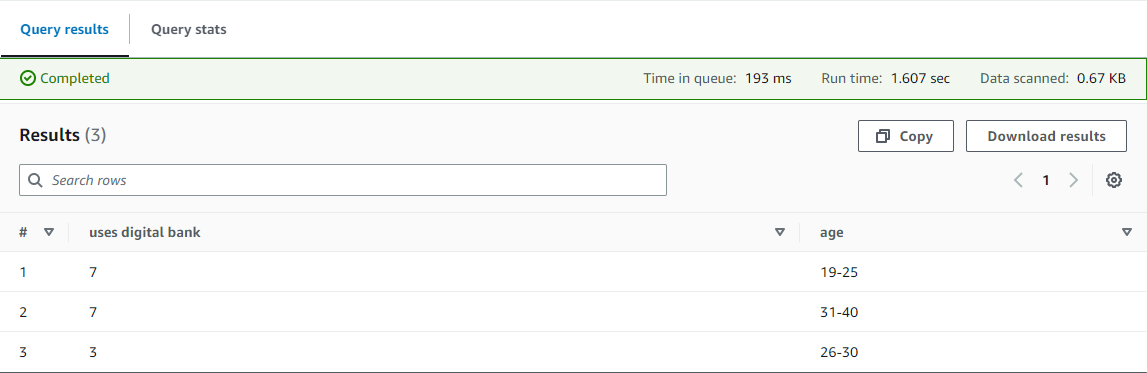


Com os dois últimos resultados, podemos ver que a aderência aos bancos digitais é bastante significativa entre os jovens adultos que compoem essa amostra.

Passando a investigar como os indivíduos na amostra investem seu dinheiro:
```sql
SELECT COUNT(*) as "Count", age, investment FROM "pesquisa" GROUP BY age, investment
```
nos mostra a aderência dos indivíduos aos investimentos tradicionais - renda fixa ou renda variável

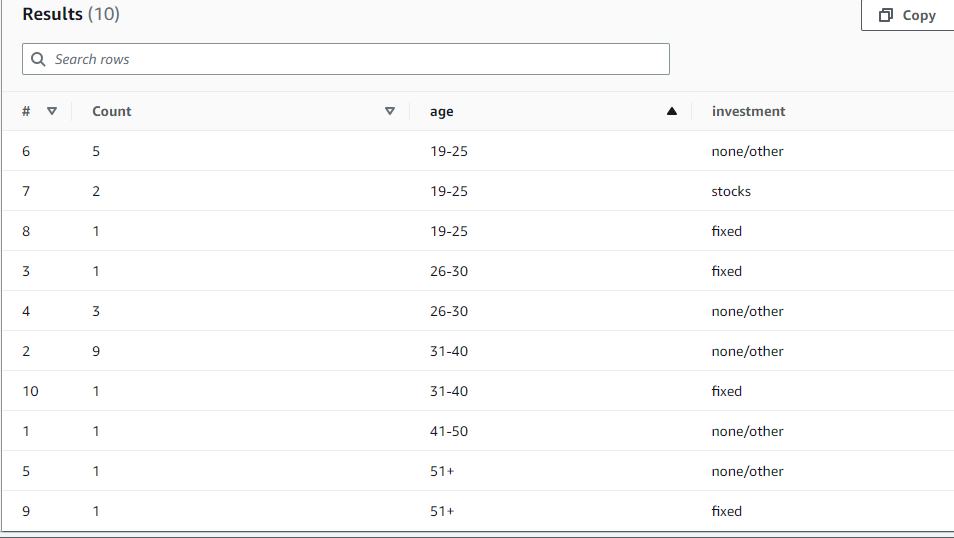

Podemos ver que a aderência é baixa, apenas 6 indivíduos possuem investimentos tradicionais. Podemos conferir se o gênero influencia na aquisição de investimentos.

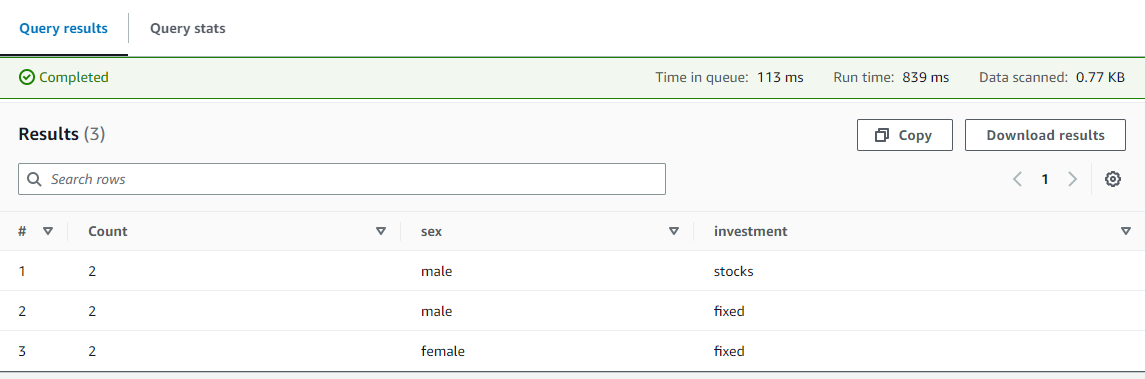

Nessa amostra, a predominância de investidores é dos homens.